In [1]:
#!/usr/bin/env python
# coding: utf-8

%load_ext autoreload
%autoreload 2



import torch, datetime, click
torch.set_default_tensor_type(torch.cuda.FloatTensor)

import swyft
from utils import *
from data_mgmt import get_paths, get_ids

from plot import *

imkwargs = dict(extent=(-2.5, 2.5, -2.5, 2.5), origin='lower') #left, right, bottom, top

In [2]:
DEVICE = 'cuda'



m = 1
nsub = 2
nsim = 1000

nmc = 1
sigma = 0.0

lr = 1e-3
factor = 1e-1
patience = 5
max_epochs = 10

zero = 'toy'

In [3]:
time_start = datetime.datetime.now()

def noise(obs, _= None, sigma_n = sigma):
    image = obs["image"]
    eps = np.random.randn(*image.shape) * sigma_n
    return {"image": image + eps}

# Set definitions (should go to click)
systemname = "ngc4414"

# Set utilities

store_path, dataset_path, mre_path, _ = get_paths(dict(m=m,nsub=nsub,nsim=nsim,nmc=nmc,sigma=sigma,zero=zero))

store = swyft.Store.load(path=store_path)
print(f'Store has {len(store)} simulations.')

torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK
config = get_config(systemname, str(nsub), str(m))
torch.set_default_tensor_type(torch.FloatTensor)

prior, n_pars, lows, highs = get_prior(config)
L = config.kwargs["defs"]["nx"]
print(f'Image has L = {L}.')

dataset = swyft.Dataset(nsim, prior, store, simhook = noise)


Loading existing store.
Store has 965 simulations.
Image has L = 40.


In [4]:
dataset[0]

({'image': tensor([[3.0149e-06, 2.7795e-06, 1.6990e-06,  ..., 0.0000e+00, 0.0000e+00,
           0.0000e+00],
          [6.2049e-05, 5.7203e-05, 3.4966e-05,  ..., 4.2039e-45, 0.0000e+00,
           0.0000e+00],
          [8.4670e-04, 7.8058e-04, 4.7714e-04,  ..., 6.7557e-42, 3.0829e-44,
           0.0000e+00],
          ...,
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.8988e-42, 8.4078e-45,
           0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.4013e-45, 0.0000e+00,
           0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
           0.0000e+00]])},
 tensor([0.6262, 0.4977, 0.4941, 0.0077, 0.2015, 0.0586]),
 tensor([ 6.3089e-01, -1.1314e-02,  2.1740e+10, -2.4613e+00, -1.4923e+00,
          1.0718e+10]))

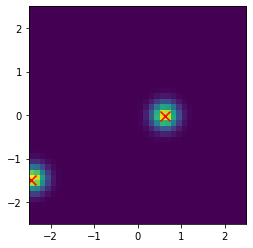

In [5]:
plt.imshow(dataset[0][0]['image'], **imkwargs)
for i in range(nsub):
    plt.scatter(*dataset[0][2][0+i*3:2+i*3], c = 'r', marker = 'x', s = 100)

In [6]:
class CustomObservationTransform(torch.nn.Module):
    def __init__(self, observation_key: str, observation_shapes: dict):
        super().__init__()
        self.observation_key = observation_key # 'image'
        self.n_features = torch.prod(torch.tensor(observation_shapes[observation_key])) # number of pixels
        self.online_z_score = swyft.networks.OnlineDictStandardizingLayer(observation_shapes)

    def forward(self, obs: dict) -> torch.Tensor:      
        x = self.online_z_score(obs)
        x = x[self.observation_key]
        x = x.view(len(x), self.n_features)
        return x

class CustomMarginalClassifier(torch.nn.Module):
    def __init__(self, n_marginals: int, n_features: int, nmbins):
        super().__init__()
                
        self.n_marginals = n_marginals # n_pars = 3 * n_sub

        self.n_features = n_features.item() # number of pixels
        self.L = int(np.sqrt(self.n_features).item())
        
        self.out_channels = nmbins * 2
        
        self.UNet = UNET(in_channels = 1, out_channels = self.out_channels)
                
    def forward(self, sims: torch.Tensor, target_map: torch.Tensor) -> torch.Tensor:
    
        sims = sims.view(-1, self.L, self.L)
        x = self.UNet(sims) # [r00, r01], [r10, r11], r[20, 21]
        
#         x = x * target_map  # [r00, r11, r20]
        x = torch.stack([x, target_map], dim=-1)

        
        x = x.view(-1, self.n_features * self.out_channels)
        
        return x
    
    

class CustomParameterTransform(torch.nn.Module):
    def __init__(self, nmbins: int, L, lows, highs) -> None:
        super().__init__()
        self.nmbins = nmbins
        self.L   = L
        self.lows = lows
        self.highs = highs
        
    def v_to_grid(self, coord_v):
              
        coorv_v10 = torch.clone(coord_v)
        
        # Transform all masses from e.g. 10^8.5 to 8.5 so they are aligned with the highs and lows
        coorv_v10[:,2::3] = torch.log10(coorv_v10[:,2::3])
        
        n = len(coord_v[0])/3
        assert n.is_integer()
        n = int(n)
          
        lows = np.full(coord_v.shape, np.tile(self.lows, n))
        highs = np.full(coord_v.shape, np.tile(self.highs, n))   
        
        grid = lambda v: (v - lows) / (highs - lows)
        coord_grid = grid(coorv_v10)
        
        return coord_grid

    def forward(self, coord_v):        
         
        coord_grid = self.v_to_grid(coord_v)
        
        n_batch =  coord_grid.shape[0]
        n_coords = coord_grid.shape[1]*2/3
        assert n_coords.is_integer()

  
        z = torch.zeros((n_batch, self.nmbins, self.L, self.L), device = DEVICE)
  
        if not (n_batch == 0 or n_coords == 0):
            
            x_grid, y_grid, m_grid = coord_grid.view(-1,3).T.to(DEVICE)            

            x_i = torch.floor((x_grid * self.L).flatten()).type(torch.long) 
            y_i = torch.floor((y_grid * self.L).flatten()).type(torch.long) 
            m_i = torch.floor( m_grid * self.nmbins).type(torch.long) 
            b_i   = torch.floor(torch.arange(0, n_batch, 1/n_coords*2).to(DEVICE)).type(torch.long)
            
            indices = tuple(torch.stack((b_i, m_i, y_i, x_i)))
            z[indices] = 1
            
        return torch.cat((1-z, z), dim = 1)

In [7]:
# Train network
print(f'Training {mre_path}!')

marginal_indices, _ = swyft.utils.get_corner_marginal_indices(n_pars)

network = get_custom_marginal_classifier(
    observation_transform = CustomObservationTransform('image', {'image': (L, L)}),
    marginal_indices = marginal_indices,
    L = L,
    nmbins = nmc, 
    lows = lows,
    highs = highs,
    marginal_classifier = CustomMarginalClassifier,
    parameter_transform = CustomParameterTransform(nmc, L, lows, highs)
)

mre = swyft.MarginalRatioEstimator(
    marginal_indices = marginal_indices,
    network = network,
    device = DEVICE,
)

_ = mre.train(dataset, max_epochs = max_epochs)

Training ../data/mre/mre_toy_m_1_nsub_2_nsim_1000_sigma_0.0_nmc_1.pt!
training: lr=0.0005, epoch=10, validation loss=4433.980469


# Predict

In [8]:
npred = 0
entry = dict(m=m,nsub=nsub,nsim=nsim,nmc=nmc,sigma=sigma,npred=npred,zero=zero)
store_path, dataset_path, mre_path, pred_path = get_paths(entry)

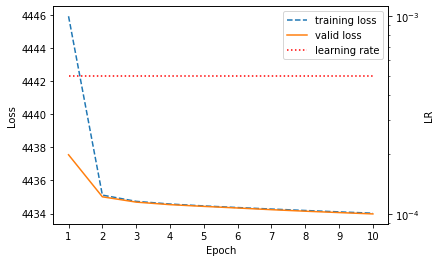

In [9]:
plot_losses(mre, save_name = get_ids(entry)[2])

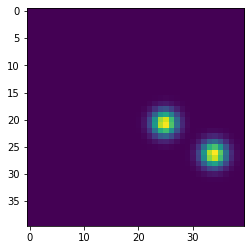

In [10]:
def get_obs(dataset, obs0_i = -1):
    obs0_i = np.random.randint(0, len(dataset)) if obs0_i == -1 else obs0_i

    obs0 = dataset[obs0_i][0]
    v0 = dataset[obs0_i][2]

    obs0['image'] = obs0['image'].unsqueeze(0).to(DEVICE, dtype = torch.float)
    v0 = v0.unsqueeze(0).to(DEVICE)

    return obs0, v0, obs0_i

def get_empty_and_full_coords(lows, highs, nmc, L):
    grid = torch.linspace(lows[0], highs[0], L+1)[:-1]
    x, y = torch.meshgrid(grid, grid, indexing = 'xy')
    m = torch.logspace(lows[-1], highs[-1], 2*nmc+1)
    m_centers, m_edges = m[1::2], m[0::2]
    ms = [torch.full((L*L,), m_i) for m_i in m_centers]

    coord_empty = torch.tensor((), device = DEVICE, dtype = torch.float).reshape(1, -1)
    coord_full = torch.cat( [torch.transpose(torch.stack((x.flatten(), y.flatten(), m)), 0, 1) for m in ms] ).reshape(1, -1).to(DEVICE, dtype = torch.float)

    return coord_empty, coord_full

obs0, v0, obs0_i = get_obs(dataset)
targets = mre.network.parameter_transform(v0).squeeze()
target = targets.numpy()
plt_imshow(obs0['image'], y = 4)

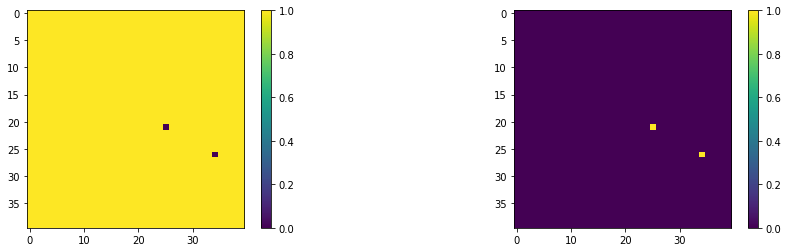

In [11]:
plt_imshow(target, cbar = True, y = 4)

In [12]:
coord_empty, coord_full = get_empty_and_full_coords(lows, highs, nmc, L)

In [13]:
def get_priors(nsub = 1, L = 40, nmc = 1):
    prior = nsub/(L*L)/nmc
    prior0 = 1 - prior
    prior1 = prior
    return prior0, prior1, np.repeat(np.array([prior0, prior1]), nmc) 
prior0, prior1, _ = get_priors()

print(prior0, prior1)

0.999375 0.000625


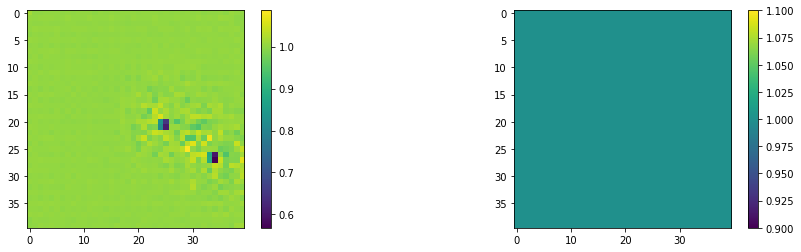

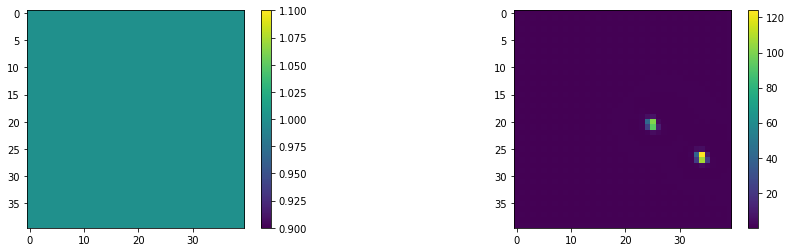

In [15]:
plt_imshow( np.exp(mre.network(obs0, coord_empty).view(2, L, L)) , cbar = True, y = 4)
plt_imshow( np.exp(mre.network(obs0, coord_full).view(2, L, L)) , cbar = True, y = 4)